# Automatic emittance measurement at LCLS-II
In this case we have 4 quadrupoles, 3 that are used to minimize the incoming beam and
 the fourth to perform the quad scan measurement.

In [1]:
from scripts.evaluate_function.lcls_ii_injector import measure_beamsize, measure_background
from scripts.optimize_function import optimize_function
from scripts.characterize_emittance import characterize_emittance

In [2]:
## import variable ranges
import pandas as pd
filename = "../../variables.csv"
VARIABLE_RANGES = pd.read_csv(filename, index_col=0, header=None).T.to_dict(orient='list')
SCREEN_NAME = "OTRS:HTR:330"

## (Optional) Measure background image

In [3]:
MEASURE_BACKGROUND = True
if MEASURE_BACKGROUND:
    measure_background(SCREEN_NAME)
    BACKGROUND_FILE = f"{SCREEN_NAME}_background.npy".replace(":","_")
else:
    BACKGROUND_FILE = None

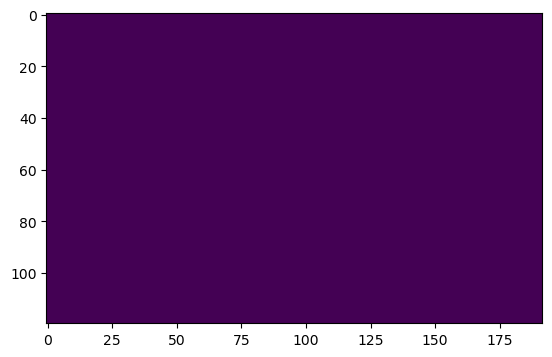

In [4]:
# verify background image
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.load(BACKGROUND_FILE))

## Define measurement parameters

In [5]:
from xopt import VOCS
import numpy as np


TUNING_VARIABLES = ["QUAD:HTR:120:BCTRL","QUAD:HTR:140:BCTRL","QUAD:HTR:300:BCTRL"]
SCAN_VARIABLE = "QUAD:HTR:320:BCTRL"
QUAD_LENGTH = 1.0 # m
DRIFT_LENGTH = 1.0 # m
BEAM_ENERGY = 0.135 # GeV
PV_TO_INTEGRATED_GRADIENT = 1.0 # kG
ROI = None
THRESHOLD = 3000

measurement_options = {
    "screen": SCREEN_NAME,
    "background": BACKGROUND_FILE,
    "threshold": THRESHOLD,
    "roi": ROI,
    "bb_half_width": 3.0, # half width of the bounding box in terms of std
    "visualize": True
}

image_constraints = {
    "bb_penalty": ["LESS_THAN", 0.0],
    "log10_total_intensity": ["GREATER_THAN", 4]
}

# define function to measure the total size on OTR4
def eval_beamsize(input_dict):
    results = measure_beamsize(input_dict)
    results["S_x_mm"] = results["Sx"] * 1e3
    results["S_y_mm"] = results["Sy"] * 1e3

    #add total beam size
    results["total_size"] = np.sqrt(results["Sx"]**2 + results["Sy"]**2)
    return results



## Optimize upstream beam parameters to minimze beamsize
Note that the scan variable is fixed at zero for maximum range quadrupole scan.

ValueError: no data found to train model!

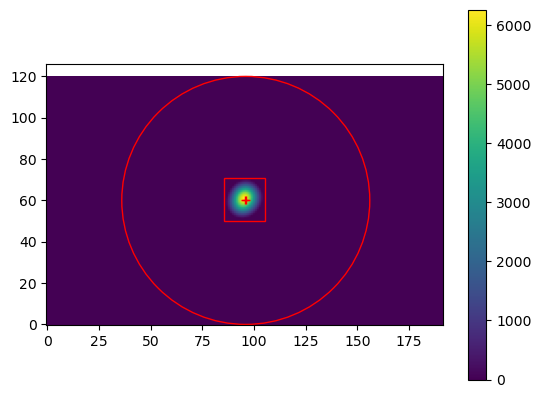

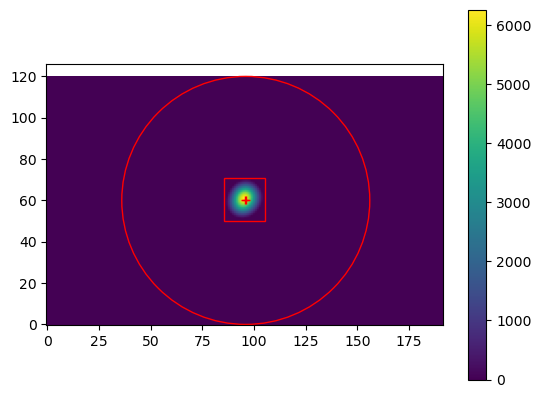

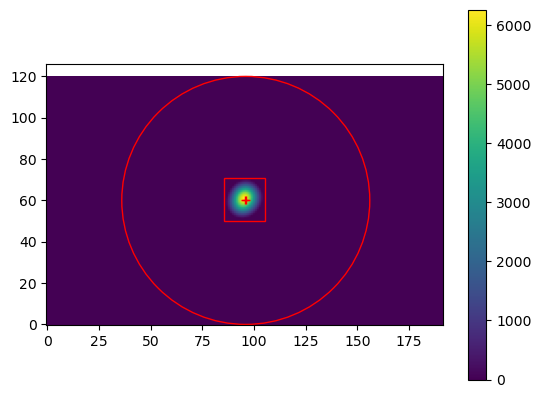

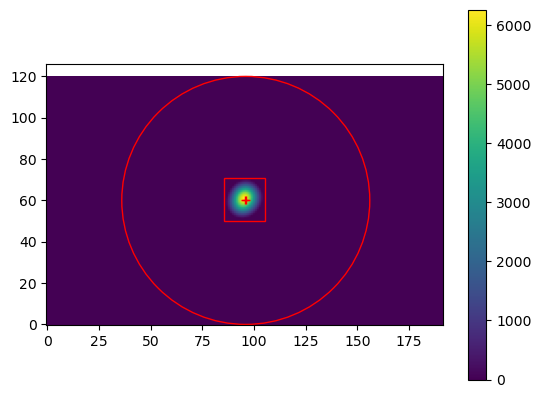

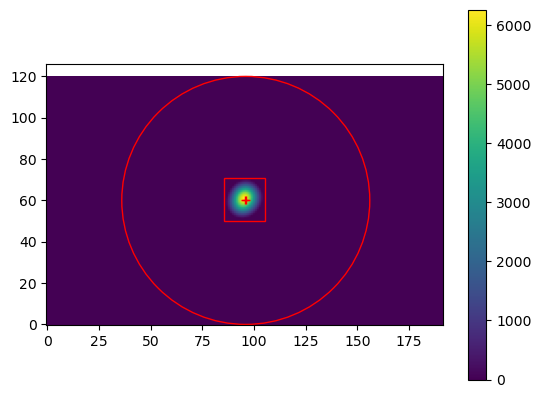

In [6]:
opt_vocs = VOCS(
        variables = {ele: VARIABLE_RANGES[ele] for ele in TUNING_VARIABLES},
        constants = {SCAN_VARIABLE: 0.0} | measurement_options,
        constraints = image_constraints,
        objectives = {"total_size": "MINIMIZE"}

    )

opt_x = optimize_function(
    opt_vocs, eval_beamsize, n_iterations=1,
)

In [ ]:
opt_x.data

## Automatic quad scan and emittance characterization

In [ ]:
from emitopt.utils import get_quad_strength_conversion_factor
emit_vocs = VOCS(
        variables = {SCAN_VARIABLE: VARIABLE_RANGES[SCAN_VARIABLE]},
        observables = ["S_x_mm", "S_y_mm"],
        constraints = image_constraints,
        constants = opt_x.data.iloc[-1][TUNING_VARIABLES].to_dict() | measurement_options
    )

# create conversion factor from PV value to geometric focusing strength
integrated_gradient_to_geometric_focusing_strength = get_quad_strength_conversion_factor(
        BEAM_ENERGY, QUAD_LENGTH
    )
quad_strength_scale_factor =  PV_TO_INTEGRATED_GRADIENT * integrated_gradient_to_geometric_focusing_strength

emit_results, emit_Xopt = characterize_emittance(
    emit_vocs,
    eval_beamsize,
    QUAD_LENGTH,
    DRIFT_LENGTH,
    quad_strength_key=SCAN_VARIABLE,
    quad_strength_scale_factor=quad_strength_scale_factor,
    rms_x_key="S_x_mm",
    rms_y_key="S_y_mm",
    quad_scan_analysis_kwargs={"visualize": True}
)

In [ ]:
emit_results

In [ ]:
emit_Xopt.data